# Capstone 3 - Customer Churn Prediction for Telco

In our previous [Notebook](https://github.com/dvanheeswijk/Springboard/blob/master/Capstone_3/Capstone%203%20-%20EDA.ipynb), we explored our data set to find any possible leads to areas to focus on for our modeling. We found that bigger cities had larger churn volumes, while a few cities also had much higher percentages of churn than most others, specifically smaller cities with a handful of customers. We also saw that Fiber Optics customers were almost twice as likely to churn as DSL customers or customers with no internet service. Lastly, we saw that the primary reasons for leaving were basically either competitive offers from other companies or poor service attitude when dealing with troubleshooting issues. 

We will now explore *clean_data.csv*, our preprocessed data set and create training and testing data sets in order to evaluate models.

We start with importing the data and necessary libraries.

In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
# from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score,roc_curve,scorer

C:\Users\david\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [90]:
data = pd.read_csv('data/clean_data.csv')

data.head()

,CustomerID,Zip Code,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,...,Internet Service_DSL,Internet Service_Fiber optic,Internet Service_No,Contract_Month-to-month,Contract_One year,Contract_Two year,Payment Method_Bank transfer (automatic),Payment Method_Credit card (automatic),Payment Method_Electronic check,Payment Method_Mailed check
0,3668-QPYBK,90003,33.964131,-118.272783,0,0,0,0,2,1,...,1,0,0,1,0,0,0,0,0,1
1,9237-HQITU,90005,34.059281,-118.307420,1,0,0,1,2,1,...,0,1,0,1,0,0,0,0,1,0
2,9305-CDSKC,90006,34.048013,-118.293953,1,0,0,1,8,1,...,0,1,0,1,0,0,0,0,1,0
3,7892-POOKP,90010,34.062125,-118.315709,1,0,1,1,28,1,...,0,1,0,1,0,0,0,0,1,0
4,0280-XJGEX,90015,34.039224,-118.266293,0,0,0,1,49,1,...,0,1,0,1,0,0,1,0,0,0


In [91]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 32 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   CustomerID                                7032 non-null   object 
 1   Zip Code                                  7032 non-null   int64  
 2   Latitude                                  7032 non-null   float64
 3   Longitude                                 7032 non-null   float64
 4   Gender                                    7032 non-null   int64  
 5   Senior Citizen                            7032 non-null   int64  
 6   Partner                                   7032 non-null   int64  
 7   Dependents                                7032 non-null   int64  
 8   Tenure Months                             7032 non-null   int64  
 9   Phone Service                             7032 non-null   int64  
 10  Multiple Lines                      

In [92]:
data['CustomerID'].is_unique

True

In [93]:
data.set_index('CustomerID', inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 3668-QPYBK to 3186-AJIEK
Data columns (total 31 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Zip Code                                  7032 non-null   int64  
 1   Latitude                                  7032 non-null   float64
 2   Longitude                                 7032 non-null   float64
 3   Gender                                    7032 non-null   int64  
 4   Senior Citizen                            7032 non-null   int64  
 5   Partner                                   7032 non-null   int64  
 6   Dependents                                7032 non-null   int64  
 7   Tenure Months                             7032 non-null   int64  
 8   Phone Service                             7032 non-null   int64  
 9   Multiple Lines                            7032 non-null   int64  
 10  Online Security           

We see now that we have the data in complete numeric format, meaning that we are ready to begin training the data.

### Training the data

In [94]:
# Splitting the data between our dependent and independent variables
X = data.drop(columns='Churn Value')
y = data['Churn Value']

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=.2, random_state=42)

In [95]:
print(X_train.shape, X_test.shape)

(5625, 30) (1407, 30)


In [96]:
print(y_train.shape, y_test.shape)

(5625,) (1407,)


### Creating the models

#### K Means Classifier

In [97]:
param_grid = {'n_neighbors':np.arange(1,50)}

knn = KNeighborsClassifier()

clf = RandomizedSearchCV(knn, param_grid, random_state=0)
search = clf.fit(X_train, y_train)
search.best_params_

{'n_neighbors': 38}

In [98]:
knn = KNeighborsClassifier(n_neighbors=38)

knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=38)

In [99]:
from sklearn.metrics import confusion_matrix
y_pred = knn.predict(X_test)
pl = confusion_matrix(y_test,y_pred)

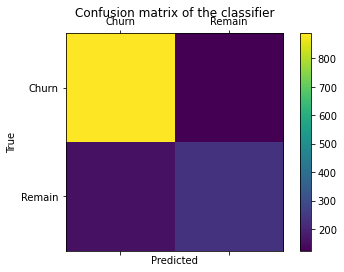

In [100]:
# plot_confusion_matrix(knn, X_test, y_test, cmap=plt.cm.Blues)
# plt.title('Confusion Matrix')
# plot_confusion_matrix(knn, X_test, y_test, cmap=plt.cm.Blues, normalize='true')
# plt.title('Normalized Matrix')
labels = ['Churn', 'Remain']


fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(pl)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [101]:
print(pl)

[[888 124]
 [158 237]]


In [102]:
auc_kmeans = roc_auc_score(y_test, y_pred)
acc_kmeans = accuracy_score(y_test,y_pred)
print(auc_kmeans, acc_kmeans)

0.7387351778656127 0.7995735607675906


As we can see, this model is alright, but we can likely do better with a different model. 

#### Ridge Classifier

In [103]:
from sklearn.model_selection import RepeatedStratifiedKFold

ridge = RidgeClassifier()

alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

param_grid = dict(alpha=alphas)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

grid = GridSearchCV(ridge, param_grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)

search = grid.fit(X_train, y_train)

search.best_params_

{'alpha': 0.7}

In [104]:
ridge = RidgeClassifier(alpha=0.7)

ridge.fit(X_train, y_train)

RidgeClassifier(alpha=0.7)

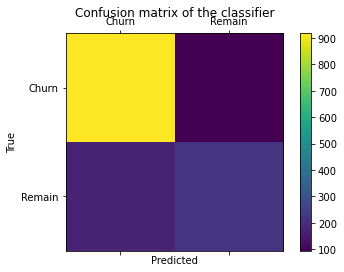

In [105]:
y_pred = ridge.predict(X_test)

pl = confusion_matrix(y_test,y_pred)

labels = ['Churn', 'Remain']


fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(pl)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [106]:
auc_ridge = roc_auc_score(y_test, y_pred)
acc_ridge = accuracy_score(y_test,y_pred)
print(auc_ridge, acc_ridge)

0.7295066793415721 0.8073916133617626


#### SVC

In [107]:
svc = SVC()

kernel = ['poly', 'rbf', 'sigmoid']
C = [50, 10, 1.0, 0.1, 0.01]
gamma = ['scale']
# define grid search
grid = dict(kernel=kernel,C=C,gamma=gamma)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=svc, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)

print(grid_result.best_params_)

{'C': 0.1, 'gamma': 'scale', 'kernel': 'sigmoid'}


In [108]:
svc = SVC(C=0.1, gamma='scale', kernel='sigmoid')

svc.fit(X_train, y_train)

SVC(C=0.1, kernel='sigmoid')

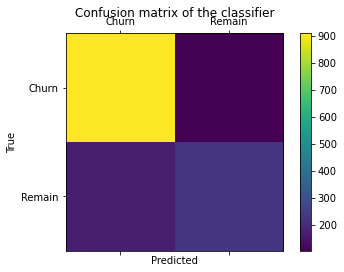

In [109]:
y_pred = svc.predict(X_test)

pl = confusion_matrix(y_test,y_pred)

labels = ['Churn', 'Remain']


fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(pl)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [110]:
auc_svc = roc_auc_score(y_test, y_pred)
acc_svc = accuracy_score(y_test,y_pred)
print(auc_svc, acc_svc)

0.7313891529494171 0.8045486851457001


## Deep learning modeling using Keras

In [150]:
from keras.layers import Dense
from keras.models import Sequential
from IPython.display import SVG
from keras.optimizers import Adam
from keras import regularizers
from keras.utils.vis_utils import model_to_dot
from keras import losses
#import pydot
from keras.utils.vis_utils import plot_model

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 64)                1984      
_________________________________________________________________
dense_21 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_22 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_23 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 9         
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


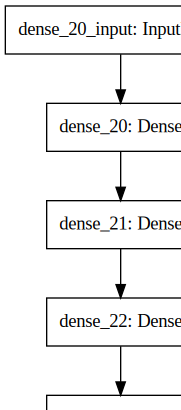

In [169]:
n_cols=X_train.shape[1]
model = Sequential()
model.add(Dense(64, input_shape=(n_cols,), activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam')
model.summary()

#plot the a graph
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [170]:
model.fit(X_train, y_train)
predictions   = model.predict(X_test)
probabilities = model.predict_proba(X_test)

model_roc_auc = roc_auc_score(y_test,predictions) 
print ("Area under curve : ",model_roc_auc,"\n")
fpr,tpr,thresholds = roc_curve(y_test,probabilities)

176/176 [==============================] - 0s 2ms/step - loss: 0.4453
Area under curve :  0.8553409716315605 



In [171]:
import plotly.graph_objects as go
#plot roc curve
trace2 = go.Scatter(x = fpr,y = tpr,
                        name = "Roc : " + str(model_roc_auc),
                        line = dict(color = ('rgb(22, 96, 167)'),width = 2))
trace3 = go.Scatter(x = [0,1],y=[0,1],
                        line = dict(color = ('rgb(205, 12, 24)'),width = 2,
                        dash = 'dot'))


In [172]:
import plotly.tools as tls
import plotly as py

fig = tls.make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]],
                            subplot_titles=('',
                                            'ROC',
                                            ''))
    
   
fig.append_trace(trace2,1,2)
fig.append_trace(trace3,1,2)

py.offline.iplot(fig)

In [173]:
acc_sequential = accuracy_score(y_test, predictions.round())

acc_sequential

0.8088130774697939

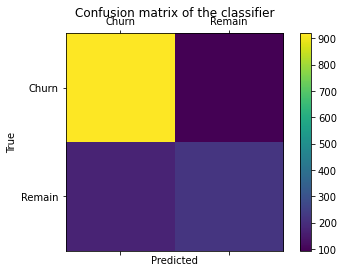

In [174]:
pl = confusion_matrix(y_test,predictions.round())

labels = ['Churn', 'Remain']


fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(pl)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [175]:
pl

array([[919,  93],
       [176, 219]], dtype=int64)

## Conclusions

We have created 4 classification models and will compare the results. First, we look at the table of ROC-AUC scores and accuracy scores to see which are the best at predicting the churn of customers.

In [178]:
scores = pd.DataFrame([['K Means', auc_kmeans, acc_kmeans], ['Ridge', auc_ridge, acc_ridge],
              ['SVC', auc_svc, acc_svc],['Sequential NN', model_roc_auc, acc_sequential]],
                      columns=['Model', 'ROC_AUC_Score', 'Accuracy_Score']
            )
scores

,Model,ROC_AUC_Score,Accuracy_Score
0,K Means,0.738735,0.799574
1,Ridge,0.729507,0.807392
2,SVC,0.731389,0.804549
3,Sequential NN,0.855341,0.808813


We see in our table of scoring that the Sequential NN is the most accurate and has the best ROC_AUC score. Of the models that are not neural networks, it appears that they are all very similar, with the Ridge Classifier being the most accurate and K Means Classifier having the best ROC_AUC score. We will need to explore further how each model makes recommendations to distinguish which is the overall best.